In [2]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [36]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer import Aer
from numpy import *
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import * 
from scipy.optimize import minimize

In [6]:
def calcualate_dist(U1, U2):
  U_dag = U1.adjoint().data
  U2 = U2.data
  tr = dot(U_dag, U2).trace()
  return sqrt(1 - (1 / 2**(2*3))* abs(tr)**2)

In [39]:
def approx_toffoli_opt(qc, params):
    theta, phi, lambda_ = params

    # choose similar unitary placement as control Z
    # but optimize our rotation angle for min HS distance
    qc.h(2)
    qc.barrier()

    # CU3 is deprecated so use cp and u gates for control unitary
    qc.cp(lambda_, 1, 2)
    qc.u(theta, phi, lambda_, 2) 
    qc.cx(0, 1)
    qc.cp(-lambda_, 1, 2)
    qc.u(-theta, -phi, -lambda_, 2) 
    qc.cx(0, 1)
    qc.barrier()
    qc.t(0)
    qc.t(2)

    qc.barrier()
    qc.h(2)
    return qc

def optimize_approx_toffoli(params):
    # define actual toffoli unitary op 
    toffoli = QuantumCircuit(3)
    toffoli.ccx(0, 1, 2)
    toffoli_op = Operator(toffoli)

    # convert our circuit to unitary op
    qc = QuantumCircuit(3, 1)
    approx_toffoli_opt(qc, params)
    my_approx_op = Operator(qc)

    # minimize HS distance 
    n = calcualate_dist(my_approx_op, toffoli_op)
    return n

# start with the params for a t gate
initial_params = array([0, 0, pi/4])

result = minimize(optimize_approx_toffoli, initial_params, method='L-BFGS-B')

print("Optimal parameters:", result.x)
print("Minimum distance:", result.fun)

Optimal parameters: [-4.27083626e-07 -3.69443273e-08  1.57077890e+00]
Minimum distance: 0.3826834324499159


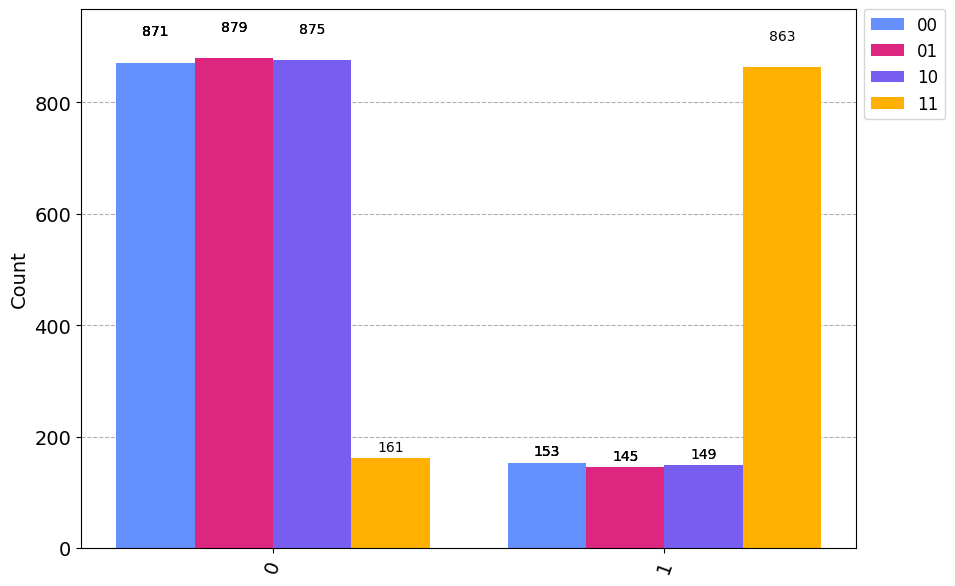

In [40]:
# test optimal circuit
opt_params = result.x

# prepare each initial state to test 00,01,10,11
qc00 = QuantumCircuit(3, 1)

qc01 = QuantumCircuit(3, 1)
qc01.x(1)

qc10 = QuantumCircuit(3, 1)
qc10.x(0)

qc11 = QuantumCircuit(3, 1)
qc11.x(0)
qc11.x(1)

for circuit in [qc00, qc01, qc10, qc11]:
    approx_toffoli_opt(circuit, opt_params)
    circuit.measure(2, 0)

results = {}
for label, qc in zip(["00", "01", "10", "11"], [qc00, qc01, qc10, qc11]):
    simulator = Aer.get_backend('qasm_simulator')
    circ = transpile(qc, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts()
    results[label] = counts

counts_list = list(results.values())

legend = ['00', '01', '10', '11']

plot_histogram(counts_list, legend=legend, figsize=(10, 7))

